# Assignment 2 (20pts)

Hey folks, this is a very fun assignment, where you'll get to combine the lessons your learned in image processing and machine learning to do your first hands-on exposure to biomedical computer vision.  In particular, the modules throughout this assignment will build up to training a supervised segmentation model for segmenting a very aggressive tumor called Glioblastoma Multiforme (GBM).  You'll be dealining with real medical data, though it's been briefly preprocessed, you will get to create every part of the machine learning pipeline, from data piping, to feature extraction, to training/testing a model.

## Necessary Modules

You'll need a few different python packages for this assignment.  If you installed python through Anaconda, you don't have to worry; the default anaconda environment should include all of these packages.  If you didn't, please `pip install` the packages as necessary.  As always, feel free to come into office hours if you are facing any problems.

In [1]:
from os import listdir, getcwd
from os.path import join

import numpy as np

import imageio as io

from skimage.filters import gabor_kernel # our gabor kernels
from skimage import exposure, morphology
from scipy import signal # will be used for fast convolutions
from sklearn import linear_model, svm, ensemble, neural_network #machine learning models

%matplotlib inline
import matplotlib.pyplot as plt

## Let's look at the cricket's chirping.

In this case, our data matrix is `temp`, which is a 15x1 data matrix.  We'll just make that a 15-long array, just to be concise.  And our target is real number array `chirps`, which is also 15-long.

In [2]:
# Inputing the dataset.
temp = np.array([89,72,93,84,81,75,70,82,69,83,80,83,81,84,76])
chirps = np.array([20,16,20,18,17,16,15,17,15,16,15,17,16,17,14])

Text(0, 0.5, 'Number of Cricket Chirps in 15s')

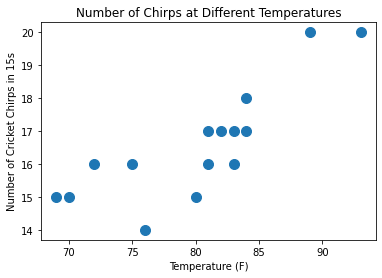

In [3]:
fig,ax = plt.subplots(1,1)
ax.scatter(temp,chirps,s=100)
ax.set_title('Number of Chirps at Different Temperatures')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Number of Cricket Chirps in 15s')

## Question 1: Loss and Derivative (1pt)

Our model loss, following lecture, will be mean squared error.  At any given value of our data matrix and targets (x and y) and our model parameters (w and b), we can calculate our loss, the derivative of our loss with respect to w, and the derivative of our loss with respect to b.

### Gradient Descent Algorithm without mean subtraction 

In [4]:
# Creating Gradient Descent Algorithm
#def calculate_gradients_MSE(x,y,w,b):
    # x is size n x p
    # y is size n
    # w is a scalar
    # b is a scalar
#    L = 0
#    dLdb = 0
#    dLdw = 0
    #---------CODE HERE---------
    # Calculate the mean squared error loss
    # and both derivatives (with respect to
    # the weight and the intercept).
    
#    L = np.sum ((y - (w*x + b))**2 )
#    L /= len(x)
#    dLdb = np.sum (-2*(y - (w*x + b)))
#    dLdb /= len(x)
#    dLdw = np.sum (-2*x.T*(y - (w*x + b)))
#    dLdw /= len(x)
        
#    pass
    #---------------------------
#    return L,dLdb,dLdw

### Gradient Descent Algorithm with mean subtraction 

In [5]:
# Creating Gradient Descent Algorithm
def calculate_gradients_MSE(x,y,w,b):
    # x is size n x p
    # y is size n
    # w is a scalar
    # b is a scalar
    L = 0
    dLdb = 0
    dLdw = 0
    #---------CODE HERE---------
    # Calculate the mean squared error loss
    # and both derivatives (with respect to
    # the weight and the intercept).
    
    yi= np.zeros(x.shape[0])
    yi = x*w+b
    L = (np.square(y - yi)).mean(axis=0)
    dLdb = -2*((y - yi).mean(axis=0))
    y_mean = y.mean(axis=0)
    x_mean = x.mean(axis=0)
    
    x_no_mean = x - x_mean                                     
    final_vector=[(y-y_mean) - (x_no_mean*w)] * x_no_mean
    dLdw = -2*(final_vector.mean(axis=1))  
    pass
    #---------------------------
    return L,dLdb,dLdw

## Gradient Descent

We can then use those derivative values to do gradient descent on our dataset.  I've given you a quick and dirty linear regression class code.  Read this class over, and make sure you understand what each part does.

Change the hyperparmeters of the model by passing in different values of `iters` and `lr`.  Find hyperparameters such that you get a final loss of less than 1.

In [6]:
class linear_regression:
    def __init__(self, iters=1, lr=1):
        self.w = 0
        self.b = 0
        self.iters = iters
        self.lr = lr
        self.log_Ls = np.zeros(iters)
        self.log_ws = np.zeros(iters)
        self.log_bs = np.zeros(iters)
    
    def fit(self, X, y):
        for ii in range(self.iters):
            # Calculate loss and derivatives
            L,dLdb,dLdw = calculate_gradients_MSE(X,y,self.w,self.b)
            # Update Step
            self.w -= self.lr * dLdw
            self.b -= self.lr * dLdb
            # Log the values.
            self.log_Ls[ii] = L
            self.log_ws[ii] = self.w
            self.log_bs[ii] = self.b
        return L
    
    def predict(self, X):
        return X * self.w + self.b

model = linear_regression(iters=45, lr=0.01)  #<- change the hyperparameters
L = model.fit(temp,chirps)
print (L)
print('Final Loss was Below 1.0: ' + str(L<1))

0.9882073970176608
Final Loss was Below 1.0: True


Text(0, 0.5, 'Number of Cricket Chirps in 15s')

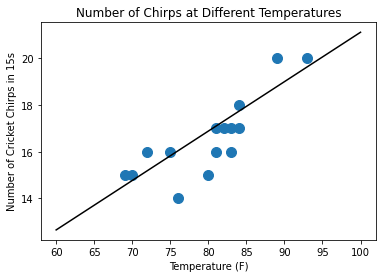

In [7]:
xs = np.array([60,100])
ys = model.predict(xs)
fig,ax = plt.subplots(1,1)
ax.scatter(temp,chirps,s=100)
ax.plot(xs,ys,'k')
ax.set_title('Number of Chirps at Different Temperatures')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Number of Cricket Chirps in 15s')

## Classification

Now let's work on the problem of classification.  Here, we'll use binary classification data that we generated randomly.

In [8]:
# Generating binary classification data
num_samples = 50
center0 = np.array([1,3])
center1 = np.array([3,1])

data0 = 1.5*np.random.randn(num_samples,2) + center0
data1 = 1.5*np.random.randn(num_samples,2) + center1

data_class = np.concatenate([data0,data1], axis=0)
target_class = np.concatenate([np.zeros(num_samples), np.ones(num_samples)], axis=0)

(-4.3, 6.3)

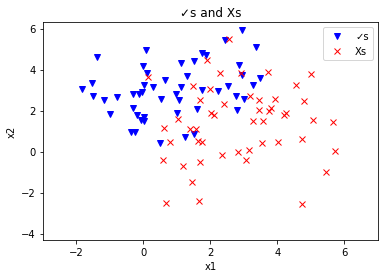

In [9]:
# Plotting the data cleanly.
fig,ax = plt.subplots(1,1)
plt.plot(data_class[target_class==0,0],data_class[target_class==0,1],'bv')
plt.plot(data_class[target_class==1,0],data_class[target_class==1,1],'rx')
plt.legend(["\u2713s","Xs"])
ax.set_title("\u2713s and Xs")
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim([-3,7])
ax.set_ylim([-4.3,6.3])

## Question 2: Derivatives (2pts)

Given a data vector $\vec{x}$ and a weight vector $\vec{w}$ with intercept (or bias) term $b$, we can calculate the logits by doing a simple linear model:

$ z = \vec{x} \cdot \vec{w} + b $

We call $z$ a logit because we will apply a sigmoid onto it.  The formula for the sigmoid of $z$ is as follows:

$ p = \sigma (z) = \frac{1}{1 + e^{-z}} $

This can be seen as the probability of the event in question being positive or negative.  Usually, to do classificaiton, we set a threshold (like 0.5), and if our probability is greater than our threshold, we return class 1; otherwise, we return class 0.

Our loss function will be cross entropy:

$ L = y * \log(p) + (y-1) * \log(p-1) $

What are the values of $ \frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b} $.

HINT: Find the values of $ \frac{\partial L}{\partial p} $, $ \frac{\partial p}{\partial z} $, $ \frac{\partial z}{\partial w} $, and $ \frac{\partial z}{\partial b} $.  Once you do, use the chain rule.

Using the chain rule: 
$$ \frac{\partial L}{\partial w} = \frac{\partial L}{\partial p} \times {\frac{\partial p}{\partial z}} \times {\frac{\partial z}{\partial w}} = $$
$$ = \frac{\partial L}{\partial z} \times {\frac{\partial z}{\partial w}} = $$
$$ = (p-y) \vec{x} $$

$$ \frac{\partial L}{\partial b} = \frac{\partial L}{\partial p} \times {\frac{\partial p}{\partial z}} \times {\frac{\partial z}{\partial b}} = $$
$$ = \frac{\partial L}{\partial z} \times {\frac{\partial z}{\partial b}} = $$
$$ = (p-y) $$





## Question 3: Sigmoid and Cross Entropy  (2 pts)

In [10]:
# Creating Gradient Descent Algorithm
def sigmax(z):
    out = np.zeros_like(z)
    #---------SIGMOID---------
    # Calculate the sigmoid for x.  
    out = 1/(1+ np.exp(-z))
    pass
    #-------------------------
    return out

def calculate_gradients_binXentropy(X,y,w,b):
    # X is size n x p (p is num_feats)
    # y is size n
    # w is size p
    # b is a scalar
    #---------CalculateLoss---------
    # Calculate the losses and the derivatives.
    # You'll be coding up your answer to Q2 here.
        
    z = (w*X + b).sum(axis=1)
    p = sigmax(z)
        
    L = (-(y * np.log (p) + (1 - y) * np.log (1 - p))).mean(axis=0)
    dLdw = np.zeros_like(X)
    dw = np.zeros_like(X)
    dLdb = 0
    
    for ix in range(len(y)):
        dw[ix,:] = ((p[ix]-y[ix])*X[ix,:])        
    
    dLdw =  dw.mean(axis=0)   
    dLdb  =  (p-y).mean(axis=0) 
    #-------------------------------
    
    return L,dLdb,dLdw

## Question 4: Logistic Regression Class (2pts)

Using the example shown to you with the class definition of `linear_regression`, create the logistic regression equivalent.

We have given you the initializations, where you have to pass in `num_feats` upon initialization.  This will initialize your model parameters, `w` an `b`.

In [11]:
class logistic_regression:
    def __init__(self, num_feats, iters, lr):
        self.w = np.zeros(num_feats)
        self.b = 0
        self.iters = iters
        self.lr = lr
        self.log_Ls = np.zeros(iters)
        self.log_ws = np.zeros((iters,num_feats))
        self.log_bs = np.zeros(iters)
    
    def fit(self, X, y):
        # X is shape n x p
        # y is shape n
        #L = 0
        #---------FIT---------
        # Do gradient descent by calculating
        # the loss, derivatives, doing the
        # gradient descent update step.
        # Do this self.iters number of times.
        for ii in range(self.iters):
            # Calculate loss and derivatives
            L,dLdb,dLdw = calculate_gradients_binXentropy(X,y,self.w,self.b)
            # Update Step
            self.w -= self.lr * dLdw
            self.b -= self.lr * dLdb
            # Log the values.
            self.log_Ls[ii] = L
            self.log_ws[ii] = self.w
            self.log_bs[ii] = self.b
            #---------------------
        return L
    
    def predict(self, X):
        # X is shape n x p
        out = np.zeros(X.shape[0])
        #---------PREDICT---------
        z = (self.w*X+self.b).sum(axis=1)
        #print(z)       
        p = sigmax(z)
        for i in range(X.shape[0]):           
            if p[i] > 0.97:
                out[i] =1
            else:                
                out[i] =0
        #-------------------------    
        return out

## Question 5: Hyperparameter Search (1pt)

Choose the hyperparameters (iters and lr) such that you get a final loss of less than 1.0.

In [12]:
model = logistic_regression(num_feats=2, iters=50, lr=0.001)  #<- change the hyperparameters
L = model.fit(data_class,target_class)

print('Final Loss was Below 1.0: ' + str(L < 1))
print(L)

Final Loss was Below 1.0: True
0.6739695127853897


## Visualizating your decision boundary

In [ ]:
xs = np.array([-2.5,6.5])
# ys = -model.w[0]/(model.w[1]+1e-6) * xs - model.b  / (model.w[1]+1e-6)
ys = -model.w[0]/(model.w[1]+1e-6) * xs - model.b  / (model.w[1]+1e-6)

fig,ax = plt.subplots(1,1)
plt.plot(data_class[target_class==0,0],data_class[target_class==0,1],'bv')
plt.plot(data_class[target_class==1,0],data_class[target_class==1,1],'rx')
plt.plot(xs,ys,'k-')
plt.legend(["\u2713s","Xs"])
ax.set_title("\u2713s and Xs")
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim([-3,7])
ax.set_ylim([-4.3,6.3])

## Let's Transition to a Real Biomedical Computer Vision Problem

Now that you understand the basics of how machine learning works, let's try extracting some features and using our machine learning knowledge to do supervised segmentation

We have two folders of data: `datatr` and `datate`, which represent your training and testing data separately.

Each piece of data has two images associated with it, a `#img.png` that represents our input X data and a `#seg.png` piece of data that holds the segmentations.  Let's see what they look like.

In [14]:
def normalize_img(img):
    out = np.zeros_like(img)
    out[:] = img[:]
    out = out.astype(np.float32)
    out -= out.min()
    out /= out.max() + 1e-6
    return out

def normalize_seg(seg):
    out = np.zeros_like(seg)
    out[:] = seg[:]
    out = (out > 0) + 0.0
    return out

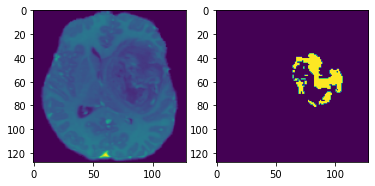

In [15]:
img = io.imread('datatr/0img.png')
seg = io.imread('datatr/0seg.png')

img = normalize_img(img)
seg = normalize_seg(seg)

fig,ax = plt.subplots(1,2)

ax[0].imshow(img)
ax[1].imshow(seg)

## Question 6: Normalization (1pt)

Why do we normalize our input image and output segmentation image differently?

I think is due to the fact that in the image we have an intensity image half precision float: sign bit, 5 bits exponent, 10 bits mantissa, while the segmented one is a binary image.

## Question 7: Gabor Filter Bank (1pt)

Here, we will extract dense features (a feature vector per pixel) using a Gabor Filter Bank.  As you recall in your lectures, we will create gabor filters at different directions and scales.  Define a list of scales and directions, and create a gabor filter for each pair.  Then append the created filter into our list of gaborfilters, called `gaborbank`.

Hint: Use the module `skimage.filters.gabor_kernel` that we imported above to create your gabor kernels.  [The API](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gabor_kernel) should point you in the right direction.  You'll notice that you need to feed in a frequency, a theta (or direction), and a scale in both the x and y direction (`sigma_x` and `sigma_y`).  For this exercise, you can set the x and y direction scale equal to each other.  Another trick many people use is to hinge the frequency to the scale, such as defining frequency to be `0.5 / scale`.  Once you create the kernel, you may notice it returns a complex number array.  Just take the real component.

In [16]:
sigmas = [1,2,3] #<- Change this to smart sigmas
#thetas = [x * np.pi / 4 for x in range(4) ] #<- Change this to smart thetas
thetas = [0,1,2,3]
gaborbank = []

for sigma in sigmas:
    for theta in thetas:
        #---------GABOR---------
        # Create a gabor_kernel given with the
        # current sigma and theta value. Then append
        # the kernel to our gaborbank list.
       # kernel = np.real(gabor_kernel(.5/sigma, theta=theta,
                                    #  sigma_x=sigma, sigma_y=sigma))
        kernel = np.real(gabor_kernel(0.5 / sigma, theta=theta/ 4. * np.pi,
                                          sigma_x=sigma, sigma_y=sigma))
        gaborbank.append(kernel)
pass
#-----------------------

## Visualizing the Gabor Filter Bank

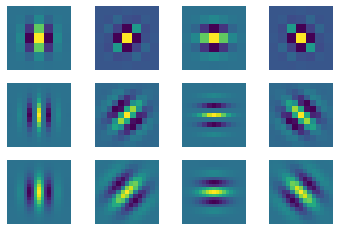

In [17]:
fig,ax = plt.subplots(len(sigmas), len(thetas))

for ii,sigma in enumerate(sigmas):
    for jj,theta in enumerate(thetas):
        ax[ii,jj].imshow(gaborbank[ii*len(thetas) + jj])
        ax[ii,jj].axis('off')

## Question 8: Convolving Our Image with a Filter Bank (1pt)

Here, we create a function `apply_filterbank` that will take in a grayscale (2-dimensional) image and apply a filter bank.  It will return a 3D array, with dimensions 0 and 1 the same as our image, but with dimension 2 the same length as our filter bank.  Each index of dimension 2 (aka `axis=2`) will represent the convolution product of one of our filters in our filter bank with our image.

Hint: Though you can use your convolution function from Assignment 1, I suggest using `scipy.signal.fftconvolve`.  Using fast fourier transforms to take a signal into fourier space, where convolutions are simple elementwise multiplications is a key trick in image processing.  This method will make your convolutions much faster than if you use your double-for-loop code from assignment 1, though you are free to do that too.  Make sure you look at the [API](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html) to understand what parameters to pass in to make sure the output is the same image size as your input image.

In [18]:
def apply_filterbank(img, filterbank):
    # img is shape M x N
    # filterbank is a list of arrays shaped m x n
    out = np.zeros((img.shape[0], img.shape[1], len(filterbank)))
    
    #---------APPLYBANK---------
    # Apply each filter in our filterbank
    # to our image and store the output in
    # the array out at the appropriate index.
    for i in range (0,len(filterbank)):
        out[:,:,i]= signal.fftconvolve(img, filterbank[:][:][i], mode='same')
    pass
    #---------------------------
        
    return out

## Visualizing our Filter Bank Application

We will visualize what our gabor filter images look like on one of our training images.

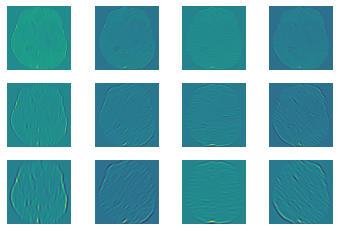

In [19]:
img = io.imread('datatr/0img.png')
img = normalize_img(img)

features_gabor = apply_filterbank(img, gaborbank)

fig,ax = plt.subplots(len(sigmas), len(thetas))
for ii,sigma in enumerate(sigmas):
    for jj,theta in enumerate(thetas):
        ax[ii,jj].imshow(features_gabor[:,:,ii*len(thetas) + jj])
        ax[ii,jj].axis('off')

## Question 9: Feature Extraction: Difference of Gaussian (DoG) Bank (2 pts)

Similarly, we will construct a difference of gaussian filter bank.  We want to first create several gaussians, all with differing scales.  Similar to SIFT features, you may want to create several gaussians of differring sigmas, each sigma being about `np.sqrt(2)` times larger than the previous one.

Then, you'll want to convolve each filter with your image, maybe using `apply_filterbank`.  But this is not a DoG feature extractor, it's just a gaussian filter extractor, right?  You can get from this to a DoG features by subtracting adjacent filter products, because subtracting the outputs of two filters on the same image is the mathematical equivalent to subtracting the filters before convolving with the image.

Hint: you may want to cannibalize some of your code from assignment 1 to help you create gaussian kernels.

In [20]:
def create_gaussian(sigma):
    # sigma is a scalar
    kernel = np.zeros((4*sigma+1))
    #---------CreateGaussian---------
    # Create a gaussian kernel with the given sigma.
    x_axis = np.linspace(-2*sigma, 2*sigma, 4*sigma) 
    y_axis = np.linspace(-2*sigma, 2*sigma, 4*sigma) 
    xx, yy = np.meshgrid(x_axis, y_axis)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    kernel /= np.sum(kernel)
    pass
    #--------------------------------
    
    return kernel

In [21]:
scales = [np.sqrt(2) ** ii for ii in np.arange(9)]

bankgaussian = [create_gaussian(int(scale)) for scale in scales]

def extract_dogfeats(img, bankgaussian):
    # img is shape M x N
    # bankgaussian is a list of filters
    features_dog = np.zeros((img.shape[0], img.shape[1], len(bankgaussian)-1))
    #---------DOG---------
    filt = apply_filterbank(img, bankgaussian)
    for i in range (0, len(bankgaussian)-1):
        features_dog [:, :, i] = filt[:, :, i]-filt[:, :, i+1]
    pass
    #---------------------
    return features_dog

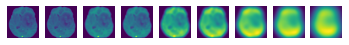

In [22]:
features_dog = np.zeros((img.shape[0], img.shape[1], len(bankgaussian)-1))

filt = apply_filterbank(img, bankgaussian)
fig,ax = plt.subplots(1, 9)
for ii in range(1):
    for jj in range(9):
        ax[jj].imshow(filt[:,:,jj])
        ax[jj].axis('off')

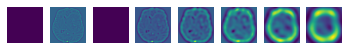

In [23]:
img = io.imread('datatr/0img.png')
img = normalize_img(img)

features_dog = extract_dogfeats(img, bankgaussian)

fig,ax = plt.subplots(1, features_dog.shape[2])

for ii in range(features_dog.shape[2]):
    ax[ii].imshow(features_dog[:,:,ii])
    ax[ii].axis('off')

## Question 10: Creating the Data Matrix (2pts)

Now we want to create our data matrix X.  If you recall, the final dimensions of our data matrix X will be `n x p`.  But before we can create it, we need to understand what our `n` and `p` are.  `n` will be the total number of pixels in our training set, because we are treating our segmentation problem as a pixelwise classification problem.

To be concrete, we have 9 pieces of data (images) in our training folder.  Each image is 128x128 pixels.  Thus, in total, our `n=147456`.  What about our `p`?   Well, these will be the extracted Gabor and DoG features you did above.  The total length of `p` will depend on what values of and how many values of scale and direction you chose for your filterbanks.

For every image (from `0img.png` to `8img.png`), you will read in the image, create the `features_gabor` and `features_dog` array for each one.  Then, concatenate the `features_gabor` and `features_dog` array for every image.  We will call this array `features_total`.  You should have 9 `128x128xp` arrays at this point.  Using whatever means you want, turn these 9 separate `128x128xp` arrays into a single `147456xp` array.

Hint: Use the `np.reshape` and `np.concatenate`.

Hint: Use some type of for-loop to loop over your dataset and read in each image.

In [24]:
p=features_gabor.shape[2]+features_dog.shape[2];

X = np.zeros((147456, features_gabor.shape[2]+features_dog.shape[2]))
data = np.empty((0, 20))
features_gabor = np.zeros((128, 128, features_gabor.shape[2], 9))
features_dog = np.zeros((128, 128, features_dog.shape[2], 9))

#---------DataMatrix---------
# Loop over all data, extract the features,
# and then concatenate and reshape as necessary
# to get our data matrix.
dir = 'datatr'
dir_path = join ( getcwd(), dir )
features_total = np.zeros((img.shape[0] * img.shape[1],len(bankgaussian)-1 + len(gaborbank)))
for filename in listdir(dir_path): 
    if filename.endswith("img.png"):
        
        #print(filename)
        img = io.imread(join(dir_path,filename))
        
        features_gabor = apply_filterbank(img, gaborbank)
        features_dog = extract_dogfeats(img, bankgaussian)
        
        for ii in range (len(bankgaussian)-2):
               features_total[:,ii] =  np.reshape(features_dog[:,:,ii],(128*128))
    
        for jj in range (len(gaborbank)-1):
              features_total[:,len(bankgaussian)+jj] =  np.reshape(features_gabor[:,:,jj],(128*128))
        #print (features_gabor.shape)
        #print (features_dog.shape)

        data=np.concatenate([data, features_total], axis=0)

X=data
print (X.shape)
print(features_total.shape)

#-----------------------------
    

(147456, 20)
(16384, 20)


## Question 11: Now we have to read in the Y (1pt)

Our Y vector should be a one-hot encoded (all entries are either 0 or 1) that is of length 147456, same as our data matrix.  Similar to before, loop over all our training images, but this time our `seg.png` images.  Make sure you follow the same array reshape steps as when you made your data matrix to ensure that all the reshapes happen in the same way.

In [25]:
Y = np.empty((0))
img = np.zeros((128, 128, 9))

#---------ReadInY---------
# Loop over all data, read the segmentations,
# and concatenate and reshape in the same
# way as with the data matrix.
dir_tr = 'datatr'
dir_path = join ( getcwd(), dir_tr )
i=0
for filename in listdir(dir_path): 
    if filename.endswith("seg.png"):
        #print(filename)
        img [:, :, i]= io.imread(join(dir_path,filename))
        lab =np.reshape(img[:,:,i],(128*128))
        Y =   np.concatenate([Y, lab], axis=0)
        #fig,ax = plt.subplots(1, 1)
        #plt.imshow(img[:,:,i],cmap='bone')
        i+=1
        
print(Y.shape)
pass
#-------------------------

(147456,)


## Question 12: Creating the Test X and Test Y (1pt)

Let's also create our test data matrix X and test data matrix Y.  We do this by going through the same procedure as with our training data, but on our single test image.  Thus, this will be a much smaller matrix (with `n=16394` and not 147,456.

In [26]:
X_test = np.zeros((16384, p))
#print (X_test.shape)
Y_test = np.zeros(16384)
features_gabor_te = np.zeros((128, 128, features_gabor.shape[2]))
features_dog_te = np.zeros((128, 128, features_dog.shape[2]))

#---------ReadInTest---------
# Read in our one test image in the
# same way as our training data.
dir_test = 'datate'
dir_path = join ( getcwd(), dir_test )

for filename in listdir(dir_path): 
    if filename.endswith("img.png"):
        img_i= io.imread(join(dir_path,filename))
        
        features_gabor_te [:, :, :] = apply_filterbank(img_i, gaborbank)
        features_dog_te  [:, :, :] = extract_dogfeats(img_i, bankgaussian)
        #print (features_gabor_te.shape)
        #print (features_dog_te.shape)
        #print (features_total_te.shape)
        for ii in range (len(bankgaussian)-2): 
               X_test[:,ii] =  np.reshape(features_dog_te[:,:,ii],(128*128))
    
        for jj in range (len(gaborbank)-1):
               X_test[:,len(bankgaussian)+jj] =  np.reshape(features_gabor_te[:,:,jj],(128*128))

        
        
    elif filename.endswith("seg.png"):
        img_s= io.imread(join(dir_path,filename))
        Y_test = np.reshape ( img_s, 128*128)
pass
#----------------------------

In [27]:
print (X_test.shape)
print (Y_test.shape)

(16384, 20)
(16384,)


## Question 13: Creating the Metrics (1pt)

For segmentation, we will use a metric score called Intersection over Union (or IoU).  This will give us a good way to judge a binary classification prediction.

If we define the set of pixels we classify as positive as $A$ and the set of pixels in the ground truth target that were positive as $B$, we define IoU as

IoU = $\frac{|A \cap B|}{|A \cup B|}$

Where $|A \cap B|$ is the total number of pixels that were classified as positive by BOTH our model AND the ground truth (True Positives).  $|A \cup B|$ is the total number of pixels that were classified as positive by EITHER out model OR the ground truth (True Positives + False Positives + False Negatives).

Another metric you could use is something called DICE:

DICE = $\frac{2 * |A \cap B|}{|A| + |B|}$

Let's just code up IoU for this homework in the method: `metric`.

In [28]:
def metric(A,B):
    # A is an array of any shape
    # B is an array of the same shape as A
    iou = 0.0
    #---------IoU---------
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection) / np.sum(union)
    #print('IoU is %s' % iou)
    iou='{0:.4g}'.format(iou) # to visualize just the first decimals 
    pass
    #---------------------
    return iou

## Question 14: Let's Train some models. (2pts)

Feel free to use your previously programmed logistic regression, but also, you can use any of the following:
- `sklearn.linear_model.LogisticRegression` [API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- `sklearn.ensemble.RandomForestClassifier` [API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- `sklearn.svm.SVC` [API](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- `sklearn.neural_network.MLPClassifier` [API](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Do note that 147,456 points of data is a lot.  Simple feature-based machine learning should still work on most recent profressional-grade laptop (like a macbook pro), but if you're running into compute issues, feel free to subsample the data (such as a random 10,000 point subsample).  Your results won't be as good, but don't worry about that.  You still learned everything.

## Previously programmed logistic regression

In [29]:
# Creating Gradient Descent Algorithm
def sigma(z):
    out = np.zeros_like(z)
    #---------SIGMOID---------
    # Calculate the sigmoid for x.  
    out = 1/(1+ np.exp(-z))
    pass
    #-------------------------
    return out

def calculate_gradients_binXentropy(X,y,w,b):
    # X is size n x p (p is num_feats)
    # y is size n
    # w is size p
    # b is a scalar
    #---------CalculateLoss---------
    # Calculate the losses and the derivatives.
    # You'll be coding up your answer to Q2 here.
        
    z = (w*X + b).sum(axis=1)
    p = sigma(z)
      
    L = (-y * np.log(p) + (1-y) * np.log(1-p)).mean(axis=0)
    dLdw = np.zeros_like(X)
    dw = np.zeros_like(X)
    dLdb = 0
    
    for ix in range(len(y)):
        dw[ix,:] = ((p[ix]-y[ix])*X[ix,:])        
    
    dLdw =  dw.mean(axis=0)   
    dLdb  =  (p-y).mean(axis=0) 
    #-------------------------------
    
    return L,dLdb,dLdw

In [30]:
print(Y_test.shape)

(16384,)


## Visualize Test Results using previously programmed logistic regression


In [36]:
model = logistic_regression(num_feats=20, iters=8, lr=0.0001)  
loss=model.fit(X,Y)
A=model.predict(X_test)
print ('IoU: ' + str(metric(Y_test,A)))

IoU: 0.3734


Text(0.5, 1.0, 'IoU: 0.3734')

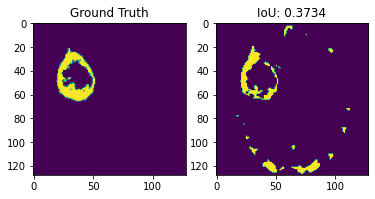

In [37]:
fig,ax = plt.subplots(1,2)

Yhat = model.predict(X_test)
ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))

## Post processing using binary morphology techniques

Morphological post-processing techniques of isolated pixel removal and closing were applied to improve the segmentation result. The increase in IoU index shows more similarity with the ground truth image. Despite this, however, the techniques were only specialized for the example image, so the procedure is not generalized to the entire dataset. The actual improvement of the IoU index is possible with a better hyperparameters tuning and with a better processing of the starting images. 

Text(0.5, 1.0, 'IoU: 0.6675')

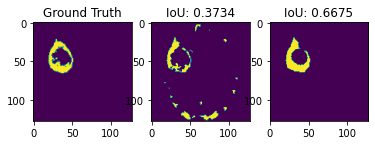

In [45]:
Yhat_morph= morphology.remove_small_objects (Yhat.reshape([128,128]).astype(bool), min_size=150, connectivity=3)
d= morphology.selem.disk(radius=9)
Yhat_morph=morphology.binary_closing(Yhat_morph, selem=d)

fig,ax = plt.subplots(1,3)

ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))
ax[2].imshow(Yhat_morph.reshape([128,128]))
ax[2].set_title('IoU: ' + str(metric(Yhat_morph.reshape([128*128]), Y_test)))

## Built-in functions and post processing 

Morphological post-processing techniques of isolated pixel removal and closing were applied to improve the segmentation result after using the suggested built-in functions. The increase in IoU index shows more similarity with the ground truth image. Despite this, however, the techniques were only specialized for the example image, so the procedure is not generalized to the entire dataset. The actual improvement of the IoU index is possible with a better hyperparameters tuning and with a better processing of the starting images.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [47]:
# Logistic regression 
lr = LogisticRegression(random_state=0, max_iter=300).fit(X, Y)
pr_lr= lr.predict(X_test)
print ('Logistic regression IoU: ' + str(metric(pr_lr,Y_test)))

Logistic regression IoU: 0.3296


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'IoU: 0.3296')

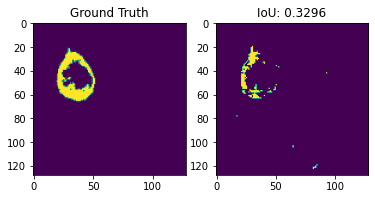

In [48]:
fig,ax = plt.subplots(1,2)

Yhat = lr.predict(X_test)
ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))

Text(0.5, 1.0, 'IoU: 0.5048')

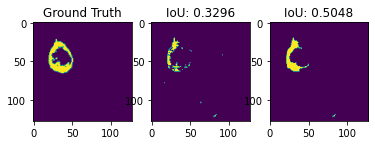

In [60]:
Yhat_morph= morphology.remove_small_objects (Yhat.reshape([128,128]).astype(bool), min_size=3, connectivity=3)
d= morphology.selem.disk(radius=5)
Yhat_morph=morphology.binary_closing(Yhat_morph, selem=d)

fig,ax = plt.subplots(1,3)

ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))
ax[2].imshow(Yhat_morph.reshape([128,128]))
ax[2].set_title('IoU: ' + str(metric(Yhat_morph.reshape([128*128]), Y_test)))

In [61]:
# Random Forest
rf = RandomForestClassifier(random_state=0).fit(X, Y)
pr_rf= rf.predict(X_test)
print ('Random Forest IoU: ' + str(metric(pr_rf,Y_test)))


Random Forest IoU: 0.5716


Text(0.5, 1.0, 'IoU: 0.5716')

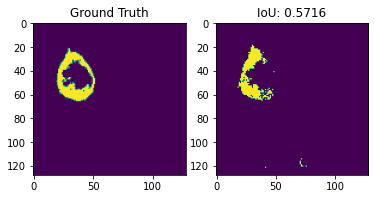

In [62]:
fig,ax = plt.subplots(1,2)

Yhat = rf.predict(X_test)
ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))

Text(0.5, 1.0, 'IoU: 0.6411')

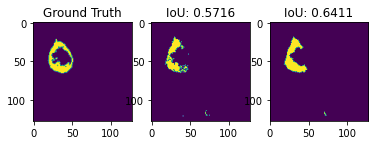

In [64]:
Yhat_morph= morphology.remove_small_objects (Yhat.reshape([128,128]).astype(bool), min_size=3, connectivity=3)
d= morphology.selem.disk(radius=3)
Yhat_morph=morphology.binary_closing(Yhat_morph, selem=d)

fig,ax = plt.subplots(1,3)

ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))
ax[2].imshow(Yhat_morph.reshape([128,128]))
ax[2].set_title('IoU: ' + str(metric(Yhat_morph.reshape([128*128]), Y_test)))

In [32]:
# SVM
svm = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X, Y)
pr_svm= svm.predict(X_test)
print ('Support Vector Machines IoU: ' + str(metric(pr_svm,Y_test)))

Support Vector Machines IoU: 0.4767


Text(0.5, 1.0, 'IoU: 0.4767')

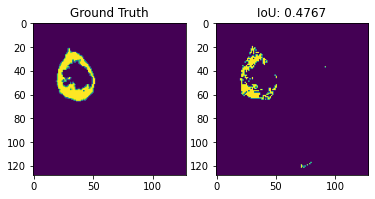

In [33]:
fig,ax = plt.subplots(1,2)

Yhat = svm.predict(X_test)
ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))

Text(0.5, 1.0, 'IoU: 0.6662')

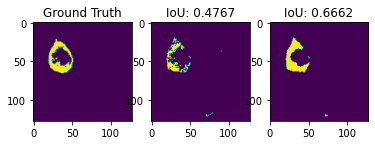

In [35]:
Yhat_morph= morphology.remove_small_objects (Yhat.reshape([128,128]).astype(bool), min_size=3, connectivity=3)
d= morphology.selem.disk(radius=5)
Yhat_morph=morphology.binary_closing(Yhat_morph, selem=d)

fig,ax = plt.subplots(1,3)

ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))
ax[2].imshow(Yhat_morph.reshape([128,128]))
ax[2].set_title('IoU: ' + str(metric(Yhat_morph.reshape([128*128]), Y_test)))

In [38]:
# NN
nn = MLPClassifier(random_state=1, max_iter=300).fit(X, Y)
pr_nn= nn.predict(X_test)
print ('Neural Network IoU: ' + str(metric(pr_nn,Y_test)))

Neural Network IoU: 0.5056


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(0.5, 1.0, 'IoU: 0.5056')

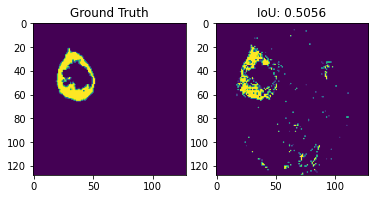

In [40]:
fig,ax = plt.subplots(1,2)

Yhat=pr_nn
ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))

Text(0.5, 1.0, 'IoU: 0.69')

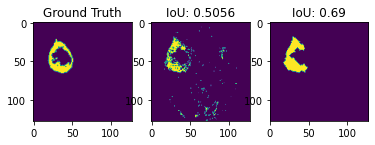

In [56]:
Yhat_morph= morphology.remove_small_objects (Yhat.reshape([128,128]).astype(bool), min_size=20, connectivity=3)
d= morphology.selem.disk(radius=2)
Yhat_morph=morphology.binary_closing(Yhat_morph, selem=d)

fig,ax = plt.subplots(1,3)

ax[0].imshow(Y_test.reshape([128,128]))
ax[0].set_title('Ground Truth')
ax[1].imshow(Yhat.reshape([128,128]))
ax[1].set_title('IoU: ' + str(metric(Yhat, Y_test)))
ax[2].imshow(Yhat_morph.reshape([128,128]))
ax[2].set_title('IoU: ' + str(metric(Yhat_morph.reshape([128*128]), Y_test)))